In [517]:
#Import packages

%matplotlib inline
import numpy as np
import pandas as pd
import re
import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, svm
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection as cv  #updated by carrie: this increase scores
from sklearn.metrics import accuracy_score # update by carrie
from sklearn.metrics import mean_squared_error as MSE
from rake_nltk import Rake
import nltk
import isodate
from sklearn.ensemble import RandomForestRegressor

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wangj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wangj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [560]:
#Import the dataset

df = pd.read_excel(r'F:\03-Data Mining Principles\Project\Data-Mining-Project\YoutubeData.xlsx')
df_original = df.copy()
df.head()

#Import list of categories to category IDs
cl = pd.read_excel(r'F:\03-Data Mining Principles\Project\Data-Mining-Project\Category_List.xlsx')

In [561]:
#Drop Unique ID for each video

df = df.drop(['video_id','video_description_short','video_thumbnail','channel_title','channel_customUrl' ], axis=1)

In [562]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14545 entries, 0 to 14544
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_title                    14544 non-null  object 
 1   video_description_full         13976 non-null  object 
 2   upload_date                    14545 non-null  object 
 3   view_count                     14538 non-null  float64
 4   like_count                     14538 non-null  float64
 5   dislike_count                  14538 non-null  float64
 6   comment_count                  14361 non-null  float64
 7   video_tags                     12097 non-null  object 
 8   video_categoryID               14545 non-null  int64  
 9   video_definition               14545 non-null  object 
 10  video_duration                 14545 non-null  object 
 11  video_caption                  14545 non-null  bool   
 12  video_licensedContent          14545 non-null 

D:\Program Files(x86)\PYTHON\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Program Files(x86)\PYTHON\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Program Files(x86)\PYTHON\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

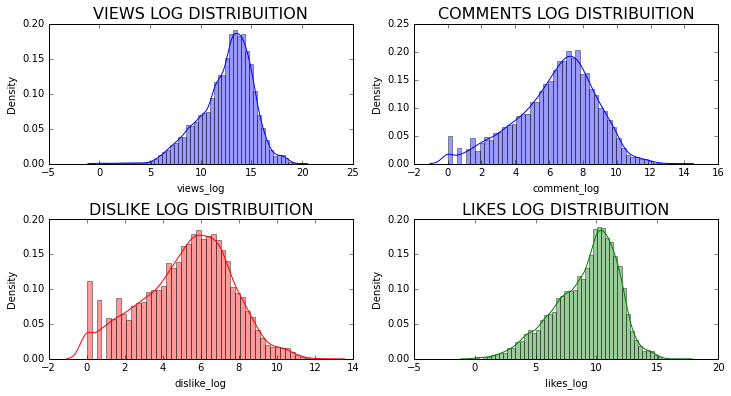

In [564]:
df['likes_log'] = np.log(df_original['like_count'] + 1)
df['views_log'] = np.log(df_original['view_count'] + 1)
df['comment_log'] = np.log(df_original['comment_count'] + 1)
df['dislike_log'] = np.log(df_original['dislike_count'] + 1)

plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(df['views_log'])
g1.set_title("VIEWS LOG DISTRIBUITION", fontsize=16)

plt.subplot(224)
g2 = sns.distplot(df['likes_log'],color='green')
g2.set_title('LIKES LOG DISTRIBUITION', fontsize=16)

plt.subplot(223)
g3 = sns.distplot(df['dislike_log'], color='r')
g3.set_title("DISLIKE LOG DISTRIBUITION", fontsize=16)

plt.subplot(222)
g4 = sns.distplot(df['comment_log'])
g4.set_title("COMMENTS LOG DISTRIBUITION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

In [565]:
#Computing a metric to assess engagement 
# comments + likes / views

#######Should we weight likes higher, or no?
#######For the sake of simplicity, maybe we should remove the denomenator

df['engagement_ratio'] = df['like_count'] # updated by carrie

df = df.drop(['like_count', 'comment_count', 'dislike_count', 'likes_log','views_log', 'comment_log', 'dislike_log'], axis=1)

In [566]:
df['engagement_ratio']

0        12462.0
1        26401.0
2        12293.0
3        22831.0
4        15161.0
          ...   
14540    28366.0
14541    21197.0
14542    23838.0
14543    20415.0
14544    17763.0
Name: engagement_ratio, Length: 14545, dtype: float64

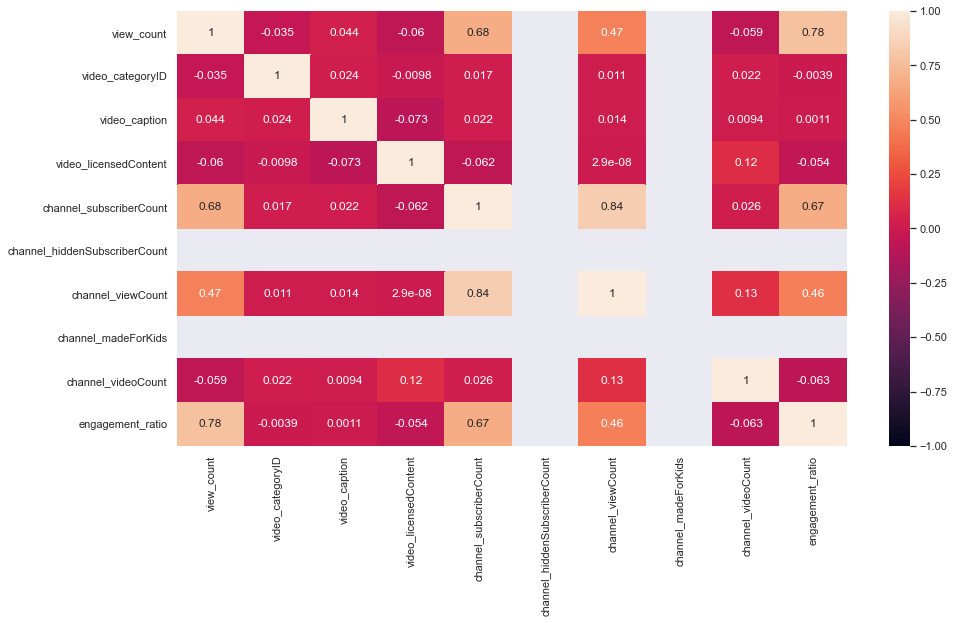

In [9]:
sns.set(rc = {'figure.figsize':(15,8)})

heatmap = sns.heatmap(df.corr(),vmin=-1, vmax=1, annot=True)

In [567]:
# Video description - to dummy
df['video_description_full'] = df['video_description_full'].fillna('na')
df['has_hyperlink'] = df['video_description_full'].apply(lambda x: 1 if 'http' in x else 0)
df['has_hyperlink'].value_counts()

1    11707
0     2838
Name: has_hyperlink, dtype: int64

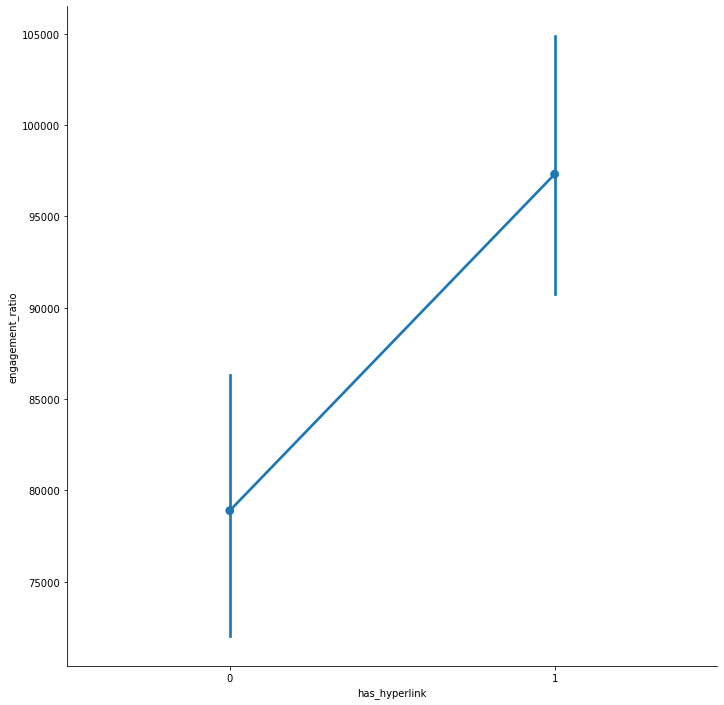

In [55]:
def plot_hyperlink(df):
    g = sns.PairGrid(data=df, x_vars=['has_hyperlink'], y_vars=['engagement_ratio'], height = 10)
    g.map(sns.pointplot)

plot_hyperlink(df=df)

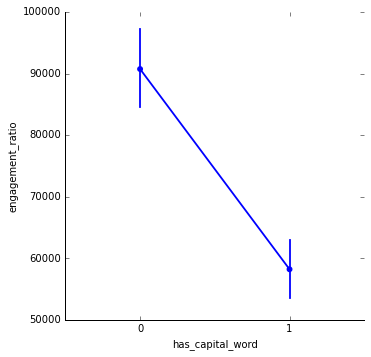

In [568]:
# Video title

# Does the video title contain at least a capitalized word (e.g. HOW) ?
df['video_title'] = df['video_title'].replace([' ', '    '], 'na') 
df = df.dropna(subset=['video_title'])

def contains_capitalized_word(t):
    for w in t.split():
        if w.isupper():
            t = 1
        else: t = 0
    return t

def plot_capital_word(df):
    g = sns.PairGrid(df, x_vars=['has_capital_word'], y_vars=['engagement_ratio'], height = 5)
    g.map(sns.pointplot)
    return g

df['has_capital_word'] = df['video_title'].apply(contains_capitalized_word)
plot_capital_word(df=df)

D:\Program Files(x86)\PYTHON\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Video Title Length Distribution'}, xlabel='Title Length', ylabel='No. of videos'>

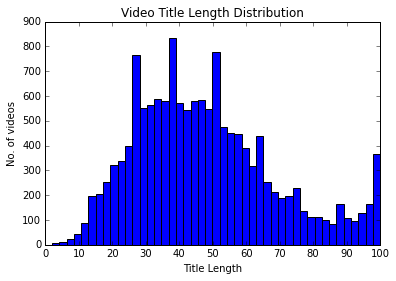

In [569]:
# video length: distribution

def plot_length_distribution(x):
    fig, ax = plt.subplots()
    sns.distplot(x, kde=False, rug=False, hist_kws={'alpha': 1}, ax=ax)
    ax.set(xlabel="Title Length", ylabel="No. of videos", xticks=range(0, 110, 10))
    ax.set_title('Video Title Length Distribution')
    return ax

df['title_length'] = df["video_title"].apply(lambda x: len(x))
plot_length_distribution(df['title_length'])
# Most videos have title lengths between 30 and 60 character approximately

<AxesSubplot:title={'center':'Relashipship between title length and engagement'}, xlabel='title length', ylabel='engagement'>

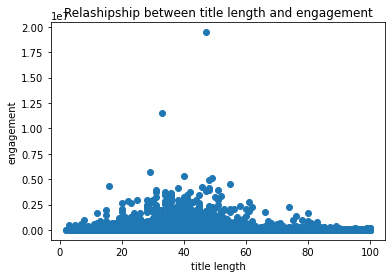

In [61]:
# Relationship between title length and engagement
def rel_title_length(df):
    fig, ax = plt.subplots()
    ax.scatter(x=df['title_length'], y=df['engagement_ratio'])
    ax.set(xlabel="title length", ylabel="engagement")
    ax.set_title('Relashipship between title length and engagement')
    return ax

rel_title_length(df=df)

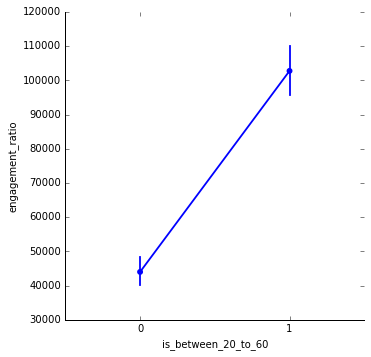

In [571]:
# Title length - to dummy
df['is_between_20_to_60'] = df['title_length'].apply(lambda x: 1 if 20<x<60 else 0)

def plot_title_dummy(df):
    g = sns.PairGrid(df, x_vars=['is_between_20_to_60'], y_vars=['engagement_ratio'], height = 5)
    g.map(sns.pointplot)
    return g

plot_title_dummy(df=df)

In [420]:
import isodate
dur = isodate.parse_duration('PT12M23S')
print(dur.total_seconds())

743.0


In [572]:
#Convert video duration to minutes + seconds

def duration_to_minutes(df):
    df['video_duration'] = df['video_duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())
    minutes = df['video_duration']/60
    minutes = minutes.astype(float).round()
    return minutes

df['video_minutes'] = duration_to_minutes(df=df)

In [573]:
df = df.drop('video_duration', axis=1)

D:\Program Files(x86)\PYTHON\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='video_minutes', ylabel='Density'>

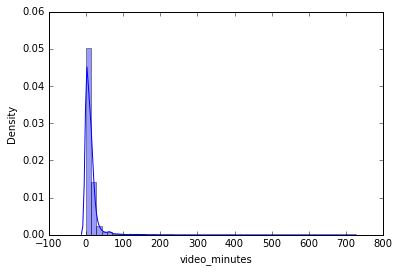

In [574]:
sns.distplot(df['video_minutes']) # distribution of video minutes: outliers

D:\Program Files(x86)\PYTHON\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='video_minutes', ylabel='Density'>

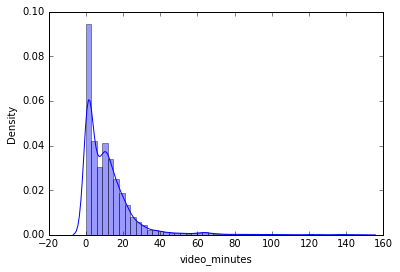

In [575]:
sns.distplot(df['video_minutes'][df['video_minutes']<150] ) # See the distribution of video minutes below 150 minutes

<AxesSubplot:title={'center':'Relationship between video minutes and engagement'}, xlabel='video_minutes', ylabel='engagement_ratio'>

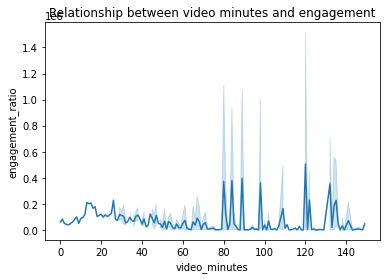

In [108]:
def plot_minutes_below_150(df):
    x = df['video_minutes'][df['video_minutes']<150]
    y = df['engagement_ratio'][df['video_minutes']<150]
    
    fig, ax = plt.subplots()
    sns.lineplot(x=x, y=y)
    ax.set_title('Relationship between video minutes and engagement')
    return ax

plot_minutes_below_150(df=df)

In [576]:
# Added by Carrie: for testing
# Make dummy variables from video duration
df['is_short'] = df['video_minutes'].apply(lambda x:1 if x<=10 else 0)
df['is_middle'] = df['video_minutes'].apply(lambda x:1 if 10<x<=40 else 0)
df['is_long'] = df['video_minutes'].apply(lambda x:1 if x>40 else 0)


array([<AxesSubplot:title={'center':'Video Duration'}, xlabel='video_duration', ylabel='count'>,
       <AxesSubplot:title={'center':'Relationship between duration and engagement'}, xlabel='video_duration', ylabel='engagement_ratio'>],
      dtype=object)

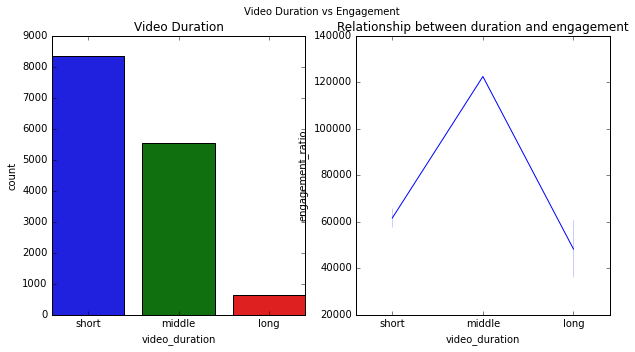

In [577]:
df['video_duration'] = df['video_minutes'].apply(lambda x: 'short' if x<=10 else ('middle' if 10<x<=40 else ('long' if x>40 else 'na')))

def plot_duration_categories(df):
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
    fig.suptitle('Video Duration vs Engagement')
    sns.countplot(x='video_duration', data=df, ax=axes[0])
    sns.lineplot(x='video_duration', y='engagement_ratio', data=df,ax=axes[1])
    axes[0].set_title('Video Duration')
    axes[1].set_title('Relationship between duration and engagement')
    
    return axes


plot_duration_categories(df=df)

In [578]:
df = df.drop('video_duration', axis=1)

In [579]:
# Added by Carrie: upload date -- frequency of posting video every month

def get_frequency_for_month(df):
    df['upload_datetime'] = pd.to_datetime(df['upload_date'])
    df['channel_title'] = df_original['channel_title']
    upload_month = df['upload_datetime'].groupby([df['upload_datetime'].dt.month, df['channel_title']]).agg('count')
    
    df_month = pd.DataFrame(upload_month)
    df_month = df_month.rename(columns={"upload_datetime": "frequency"})
    df_month = df_month.reset_index()
    df_month = df_month.rename(columns={"upload_datetime": "month"})
    return df_month

def merge_frequency_to_df(df, df_month):
    df['month'] = df['upload_datetime'].dt.month
    df = pd.merge(df, df_month, on=['month', 'channel_title'])
    return df
   
    
df_month = get_frequency_for_month(df=df)
df = merge_frequency_to_df(df, df_month)
df = df.drop(['channel_title', 'upload_datetime', 'month'], axis=1)

<ipython-input-428-5502c6f2fc59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['upload_date'] = pd.to_datetime(df['upload_date'])
<ipython-input-428-5502c6f2fc59>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['upload_date'].dt.month


array([<AxesSubplot:title={'center':'Month vs Engagement'}, xlabel='month', ylabel='engagement_ratio'>,
       <AxesSubplot:title={'center':'Frequency vs Engagement'}, xlabel='frequency', ylabel='engagement_ratio'>],
      dtype=object)

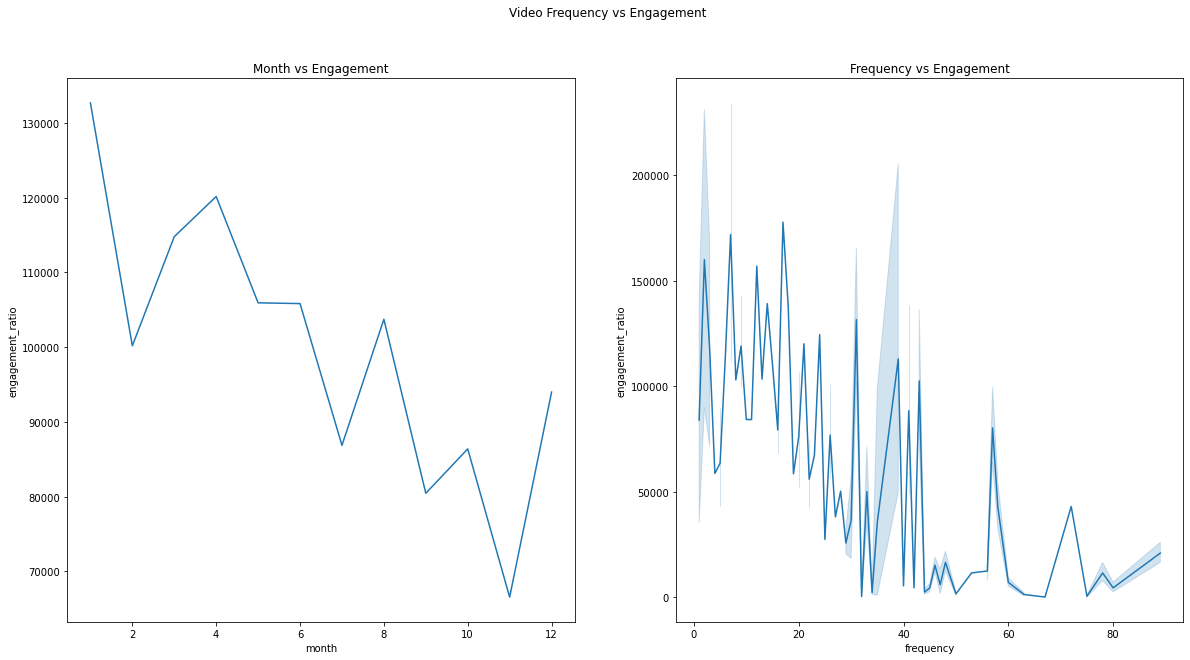

In [428]:
def plot_frequency_month(df):
    df['upload_date'] = pd.to_datetime(df['upload_date'])
    df['month'] = df['upload_date'].dt.month
    
    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    fig.suptitle('Video Frequency vs Engagement')
    sns.lineplot(x='month', y='engagement_ratio', data=df, ax=axes[0])
    sns.lineplot(x='frequency', y='engagement_ratio', data=df, ax=axes[1])
    axes[0].set_title('Month vs Engagement')
    axes[1].set_title('Frequency vs Engagement')
    return axes


plot_frequency_month(df=df[df['frequency']<100])

In [429]:
# Added by Carrie: video title
#  most common words in titles
def get_common_words(df, col):
    df['clean'] = df[col].apply(lambda x: re.sub('[^A-Za-z]+', " ", str(x)))  #remove non-words
    # Rake
    r = Rake()
    word = []
    for text in df['clean']:
        r.extract_keywords_from_text(text)
        key_words_dict_scores = r.get_word_degrees()
        word.append(key_words_dict_scores.keys())
        
    return word


from collections import Counter

titles = get_common_words(df=df, col='video_title')
title_words = list(titles)
title_words = [x for y in title_words for x in y]
Counter(title_words).most_common(25)

[('shorts', 804),
 ('vs', 793),
 ('minecraft', 618),
 ('new', 447),
 ('trailer', 409),
 ('life', 327),
 ('game', 290),
 ('hbo', 287),
 ('part', 278),
 ('official', 265),
 ('last', 229),
 ('world', 228),
 ('time', 217),
 ('fortnite', 216),
 ('interview', 212),
 ('episode', 210),
 ('day', 208),
 ('first', 208),
 ('week', 206),
 ('season', 205),
 ('get', 203),
 ('one', 200),
 ('call', 198),
 ('highlights', 191),
 ('best', 190)]

(-0.5, 1199.5, 1199.5, -0.5)

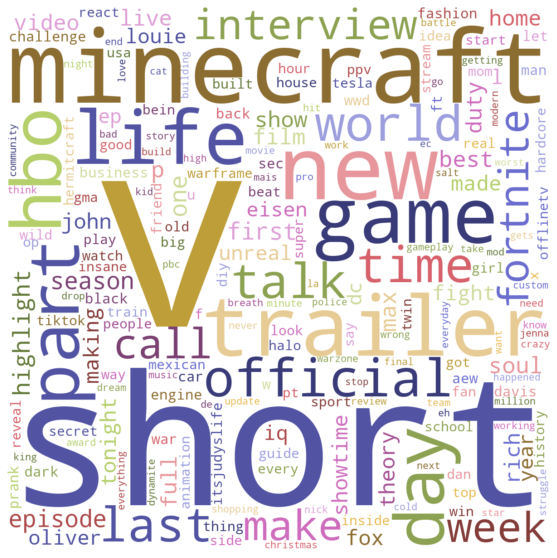

In [154]:
# Word Cloud
import wordcloud
wc = wordcloud.WordCloud(width=1200, height=1200, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(title_words))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [580]:
# Video Description

def get_clean_desc(df, col):
    df['clean'] = df[col].str.replace('http\S+|www.\S+', '', case=False) #remove hyperlinks
    df['clean'] = df['clean'].apply(lambda x: re.sub('[\W_]+', " ", str(x)))  #remove non-words
    
    r = Rake()
    des = []
    for text in df['clean']:
        r.extract_keywords_from_text(text)
        key_words_dict_scores = r.get_word_degrees()
        des.append(key_words_dict_scores.keys())
    
    df['key_words'] = des
    df['key_words'] = df['key_words'].apply(lambda x: list(x))
    return df['key_words']

df['key_words'] = get_clean_desc(df=df, col='video_description_full')
df['key_words'][0]                         

['tether',
 'printer',
 'gone',
 'overdrive',
 'made',
 'want',
 'reflect',
 'time',
 'nyag',
 'said',
 'unbacked',
 'compare',
 'today',
 'exposing',
 'video',
 'printed',
 'another',
 '2',
 'billion',
 'since',
 'big',
 'deal',
 'follow',
 'coffeezilla',
 'twitter',
 'instagram',
 'music',
 'credits',
 '3d',
 'artist',
 'ed',
 'leszczynski',
 'editor',
 'harry',
 'bagg',
 'opinion',
 'way',
 'construed',
 'statements',
 'fact',
 'scams',
 'bad',
 'business',
 'opportunities',
 'fake',
 'gurus',
 'subjective',
 'terms',
 'mean',
 'different',
 'things',
 'people',
 'think',
 'someone',
 'promises',
 '100k',
 'month',
 'upfront',
 'fee',
 '2k',
 'scam',
 'others',
 'would',
 'call',
 'napoleon',
 'hill',
 'pitch']

In [581]:
df = df.drop('clean', axis=1)

In [201]:
# Most common words in video description
word_desc = get_common_words(df=df, col='key_words')
word_desc = list(word_desc)
word_desc = [x for y in word_desc for x in y]
Counter(word_desc).most_common(25)

[('instagram', 6911),
 ('twitter', 6398),
 ('subscribe', 6260),
 ('follow', 4579),
 ('facebook', 4256),
 ('video', 3912),
 ('channel', 3830),
 ('new', 3380),
 ('get', 3113),
 ('like', 3064),
 ('music', 3005),
 ('tiktok', 2568),
 ('us', 2494),
 ('youtube', 2243),
 ('use', 2173),
 ('videos', 2092),
 ('check', 2080),
 ('com', 2027),
 ('watch', 1998),
 ('merch', 1809),
 ('time', 1796),
 ('free', 1721),
 ('make', 1686),
 ('first', 1677),
 ('discord', 1660)]

In [582]:
# Bag of words: combine 'description', 'title', 'tags'

df['video_tags'] = df_original['video_tags']
df = df.fillna({'video_tags':"['null','null']", 'channel_keywords':"null null", 'channel_description':"null null"})

df['video_tags'] = df['video_tags'].apply(lambda x: eval(x))

In [583]:
df['bag_of_words'] = df['key_words'] + df['video_tags']

In [584]:
# By Carrie: word to vector
import gensim
from gensim.models import Word2Vec

def get_vectors_from_text(sentences):
    model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)
    model.save("word2vec.model")
    
    keys = ['game', 'sport', 'film', 'music', 'kid', 'world', 'money', 'news']
    
    embedding_clusters = []
    word_clusters = []
    
    for word in keys:
        embeddings = []
        words = []
        
        for similar_word, _ in model.wv.most_similar(word, topn=30):
            words.append(similar_word)
            embeddings.append(model.wv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return embedding_clusters, word_clusters

embedding_clusters, word_clusters = get_vectors_from_text(sentences=df['bag_of_words'])

In [585]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

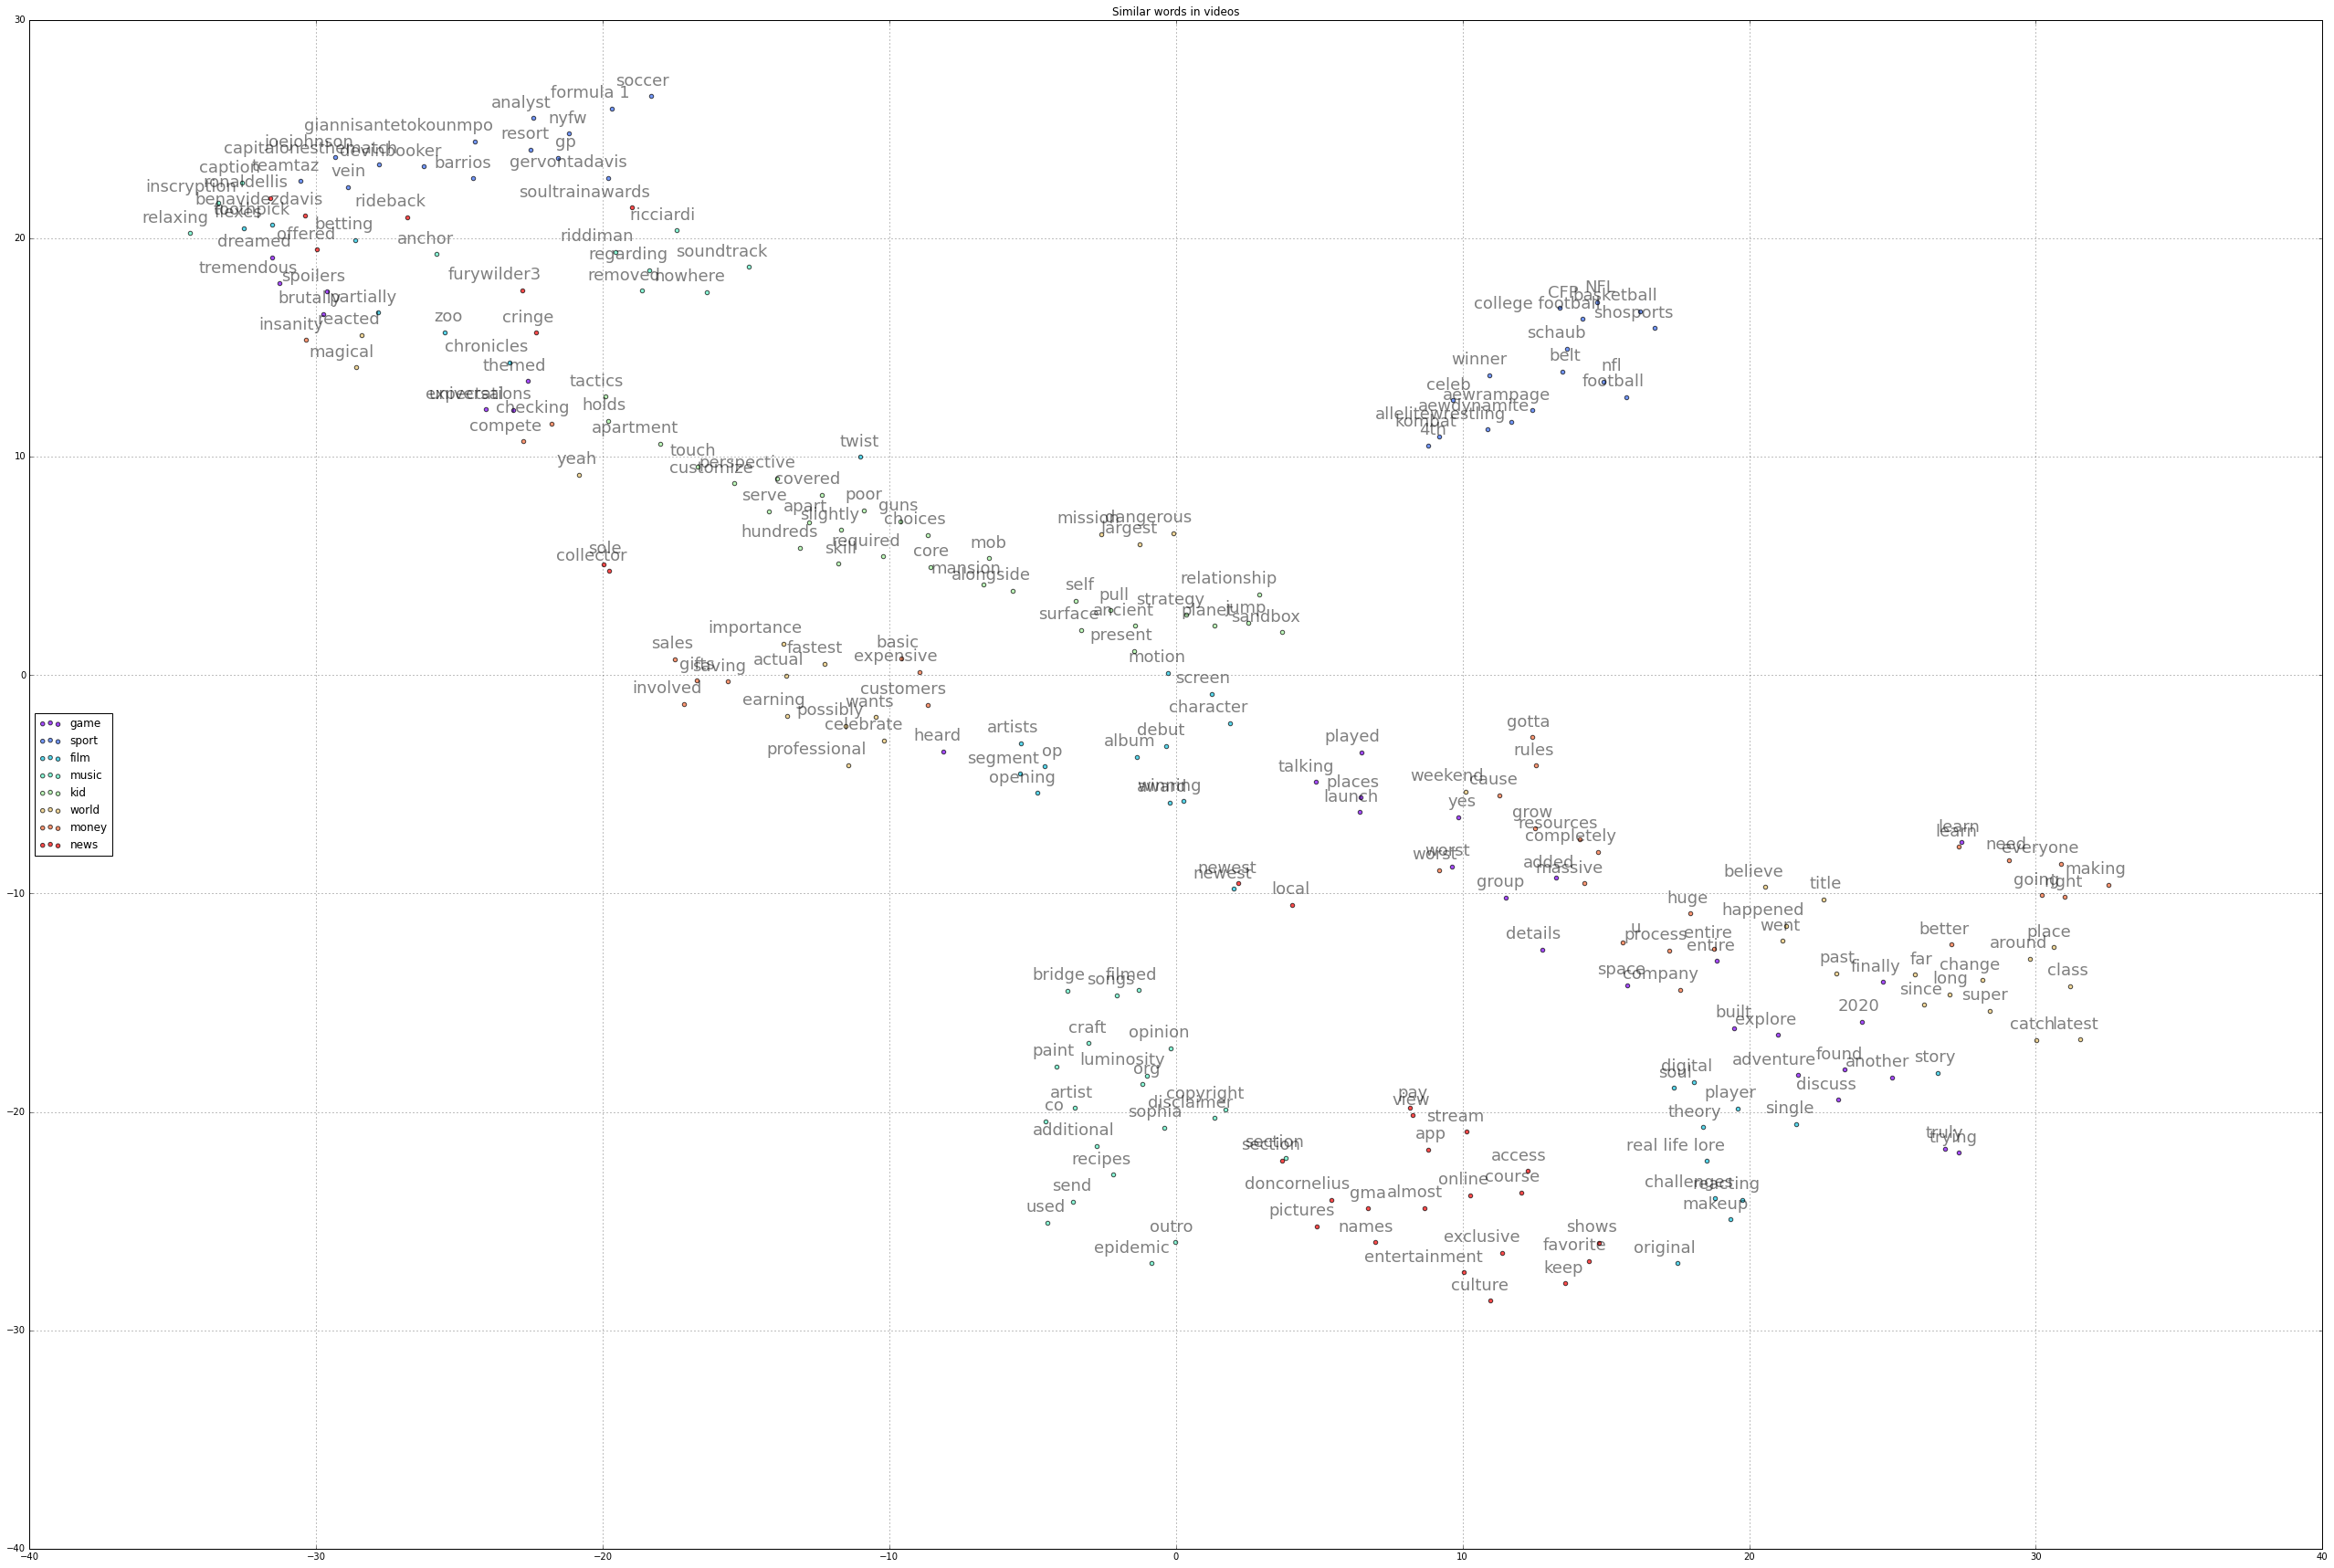

In [586]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#% matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(45, 30))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(20, 8),
                         textcoords='offset points', ha='right', va='bottom', size=18)
    plt.legend(loc=6)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words in videos', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

In [230]:
import gensim.downloader as api
wv = api.load("glove-twitter-25")  # download the model and return as object ready for use
wv.most_similar("cat")

[('dog', 0.9590820074081421),
 ('monkey', 0.920357882976532),
 ('bear', 0.9143136739730835),
 ('pet', 0.9108031392097473),
 ('girl', 0.8880629539489746),
 ('horse', 0.8872726559638977),
 ('kitty', 0.8870542049407959),
 ('puppy', 0.886769711971283),
 ('hot', 0.886525571346283),
 ('lady', 0.8845519423484802)]

In [587]:
def vectorize(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in wv:
                try:
                    vectors.append(wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(df['bag_of_words'], model=wv)
len(vectorized_docs), len(vectorized_docs[0])

(14544, 25)

In [588]:
def mbkmeans_clusters(
    X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [439]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
clustering, cluster_labels = mbkmeans_clusters(
    X=vectorized_docs,
    k=50,
    mb=500,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": df['video_title'],
    "tokens": [" ".join(text) for text in df['bag_of_words']],
    "cluster": cluster_labels
})

For n_clusters = 50
Silhouette coefficient: 0.18
Inertia:6346.560344368705
Silhouette values:
    Cluster 4: Size:496 | Avg:0.97 | Min:0.10 | Max: 0.98
    Cluster 11: Size:142 | Avg:0.96 | Min:0.22 | Max: 0.98
    Cluster 39: Size:61 | Avg:0.89 | Min:0.10 | Max: 0.93
    Cluster 13: Size:23 | Avg:0.88 | Min:0.15 | Max: 0.95
    Cluster 6: Size:149 | Avg:0.83 | Min:0.02 | Max: 0.89
    Cluster 3: Size:139 | Avg:0.70 | Min:0.08 | Max: 0.78
    Cluster 43: Size:138 | Avg:0.53 | Min:0.01 | Max: 0.66
    Cluster 5: Size:326 | Avg:0.53 | Min:0.03 | Max: 0.66
    Cluster 32: Size:149 | Avg:0.35 | Min:0.04 | Max: 0.51
    Cluster 17: Size:150 | Avg:0.31 | Min:0.01 | Max: 0.47
    Cluster 26: Size:185 | Avg:0.29 | Min:-0.04 | Max: 0.48
    Cluster 31: Size:435 | Avg:0.26 | Min:-0.06 | Max: 0.44
    Cluster 36: Size:166 | Avg:0.24 | Min:-0.01 | Max: 0.40
    Cluster 37: Size:147 | Avg:0.24 | Min:-0.07 | Max: 0.43
    Cluster 33: Size:216 | Avg:0.23 | Min:-0.03 | Max: 0.41
    Cluster 0: Size:19

In [589]:
df_clusters

,text,tokens,cluster
0,Tether Has Lost Their Mind,tether printer gone overdrive made want reflec...,26
1,Youtube Removes Dislikes From Videos,one step closer advertiser utopia bad people t...,26
2,This Has To Stop...,shiba floki doge coin gotten insanely positive...,26
3,Jake Paul Thought He'd Get Away With This...,boxing sponsorship jake paul twists nobody dis...,26
4,Squid Game But It's a Crypto Scam,squid game crypto crashed 100 blame follow cof...,26
...,...,...,...
14539,seeing our makeup palette in ulta!!!! *insane*,guys sooo surreal seeing makeup palette ulta t...,19
14540,"online shopping haul!! nike , princess polly, ...",welcome non sponsored online shopping haul got...,40
14541,trying model skincare secrets + filming w/ remi!!,sharing model skincare secrets learned cause h...,19
14542,new vlog camera setup + my own makeup palette!...,um sooo huge news remi makeup palette w tarte ...,29


In [590]:
df = pd.merge(df, df_clusters, left_on='video_title', right_on='text', how ='left')
df = df.drop(['text', 'tokens', 'key_words', 'video_tags'], axis=1)
df.head()

,video_title,video_description_full,upload_date,view_count,video_categoryID,video_definition,video_caption,video_licensedContent,channel_description,channel_publishedAt,...,has_capital_word,title_length,is_between_20_to_60,video_minutes,is_short,is_middle,is_long,frequency,bag_of_words,cluster
0,Tether Has Lost Their Mind,Tether's printer has gone into overdrive and i...,2021-11-12,218804.0,24,hd,False,True,"I uncover scams, fraudsters and fake gurus tha...",2018-08-04T03:58:25Z,...,0,26,1,6.0,1,0,0,6,"[tether, printer, gone, overdrive, made, want,...",26
1,Youtube Removes Dislikes From Videos,One step closer to the advertiser Utopia of no...,2021-11-11,226982.0,24,hd,False,True,"I uncover scams, fraudsters and fake gurus tha...",2018-08-04T03:58:25Z,...,0,36,1,16.0,0,1,0,6,"[one, step, closer, advertiser, utopia, bad, p...",26
2,This Has To Stop...,"Shiba, Floki and Doge Coin have gotten insanel...",2021-11-10,203056.0,24,hd,False,True,"I uncover scams, fraudsters and fake gurus tha...",2018-08-04T03:58:25Z,...,0,19,0,10.0,1,0,0,6,"[shiba, floki, doge, coin, gotten, insanely, p...",26
3,Jake Paul Thought He'd Get Away With This...,This boxing sponsorship with Jake Paul had a f...,2021-11-09,369053.0,24,hd,False,True,"I uncover scams, fraudsters and fake gurus tha...",2018-08-04T03:58:25Z,...,0,44,1,10.0,1,0,0,6,"[boxing, sponsorship, jake, paul, twists, nobo...",26
4,Squid Game But It's a Crypto Scam,SQUID GAME CRYPTO JUST CRASHED BY 100%. WHO'S ...,2021-11-04,284484.0,24,hd,False,True,"I uncover scams, fraudsters and fake gurus tha...",2018-08-04T03:58:25Z,...,0,33,1,9.0,1,0,0,6,"[squid, game, crypto, crashed, 100, blame, fol...",26


In [30]:
#Convert category codes to categories and change to dummy variables

In [591]:
df = pd.merge(df, cl, on ='video_categoryID', how ='left')

In [592]:
df['video_category'].value_counts()

Gaming                   3519
Entertainment            2949
People & Blogs           2325
Sports                   1130
Comedy                    917
Howto & Style             784
Education                 663
Film & Animation          629
Science & Technology      623
Autos & Vehicles          413
Music                     388
News & Politics           287
Pets & Animals              3
Nonprofits & Activism       1
Travel & Events             1
Name: video_category, dtype: int64

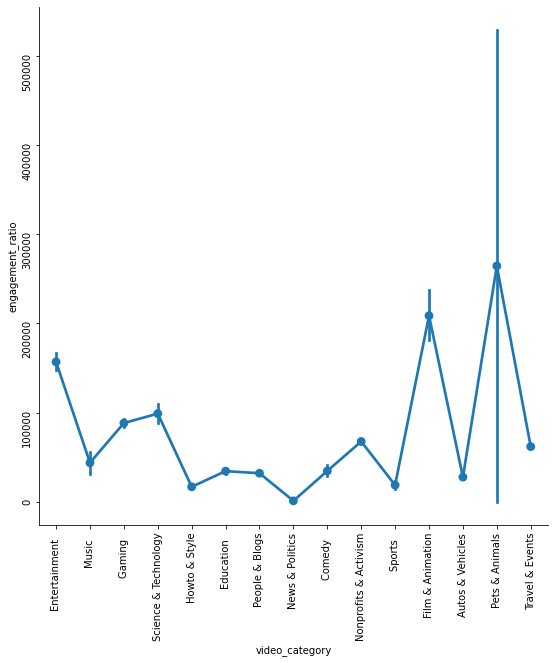

In [363]:
def plot_category_distribution(df):
    g = sns.PairGrid(df, x_vars=['video_category'], y_vars=['engagement_ratio'], height = 8)
    g.map(sns.pointplot)
    
    for ax in g.axes.flatten():
        ax.tick_params(rotation = 90)

plot_category_distribution(df=df)

In [593]:
df = df.drop('video_categoryID', axis=1)

In [594]:
df = pd.get_dummies(df, prefix=['is_'], columns=['video_category'])

In [595]:
####drop categories with less than 100
df = df.drop(['is__Pets & Animals','is__Travel & Events','is__Nonprofits & Activism'], axis=1)

In [37]:
df['video_definition'].value_counts()

hd    14393
sd      151
Name: video_definition, dtype: int64

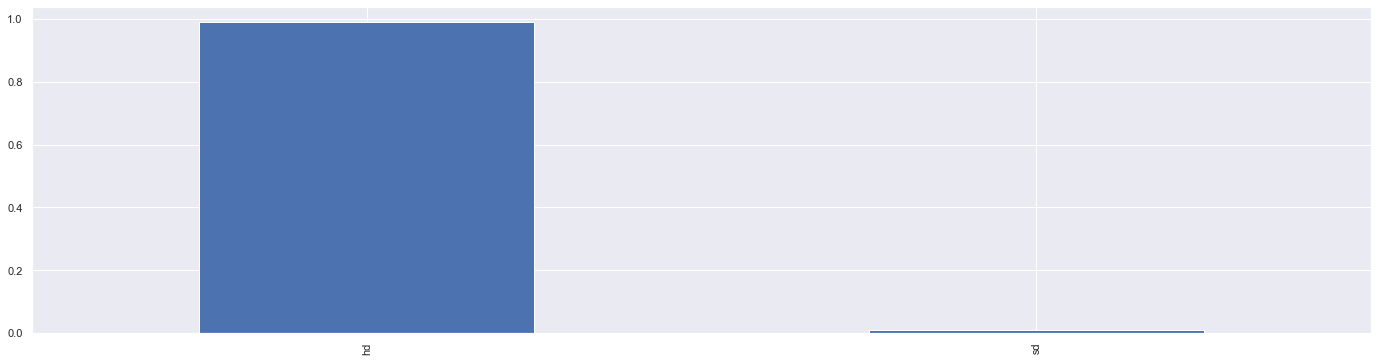

In [38]:
df['video_definition'].value_counts(normalize=True).plot.bar(figsize=(24,6))
plt.show()

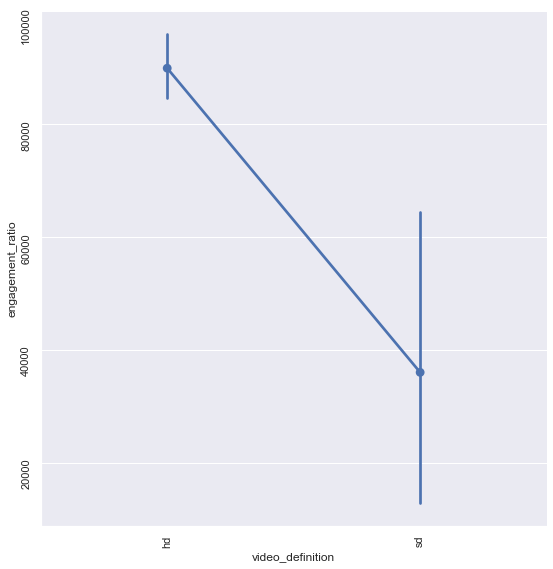

In [39]:
g = sns.PairGrid(df, x_vars=['video_definition'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

In [596]:
df['is_hd'] = df['video_definition'].apply(lambda x:1 if x=='hd' else 0)

In [597]:
df = df.drop('video_definition', axis=1)

In [598]:
df['is_length <=10'] = df['video_minutes'].apply(lambda x:1 if x<=10 else 0)

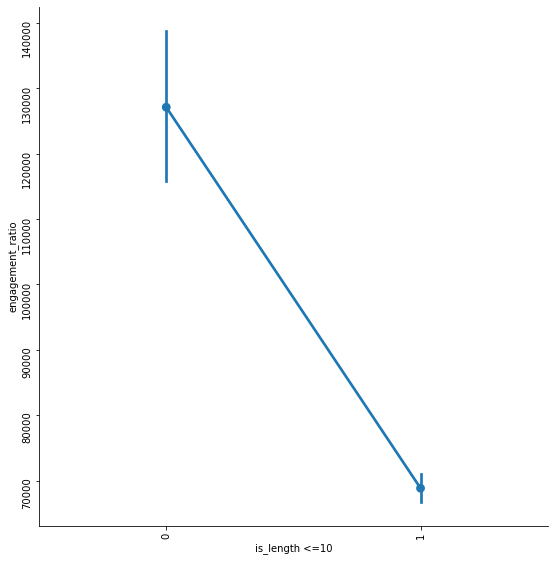

In [370]:
g = sns.PairGrid(df, x_vars=['is_length <=10'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

In [46]:
# Carrie: can we keep minutes?
#df = df.drop('video_minutes', axis=1)  # updated by carrie

In [452]:
df['is_length <=10'].sum()

8449

In [453]:
df['video_caption'].value_counts()

False    12389
True      2243
Name: video_caption, dtype: int64

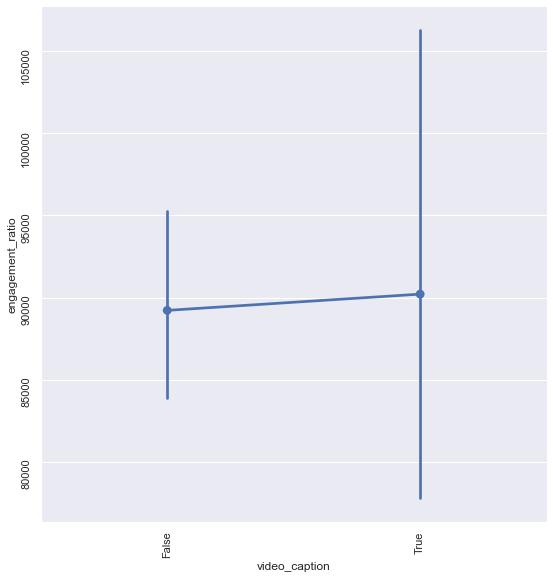

In [49]:
g = sns.PairGrid(df, x_vars=['video_caption'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

In [599]:
df = df.drop(['video_caption'], axis=1)

In [51]:
df['video_licensedContent'].value_counts()

True     12265
False     2279
Name: video_licensedContent, dtype: int64

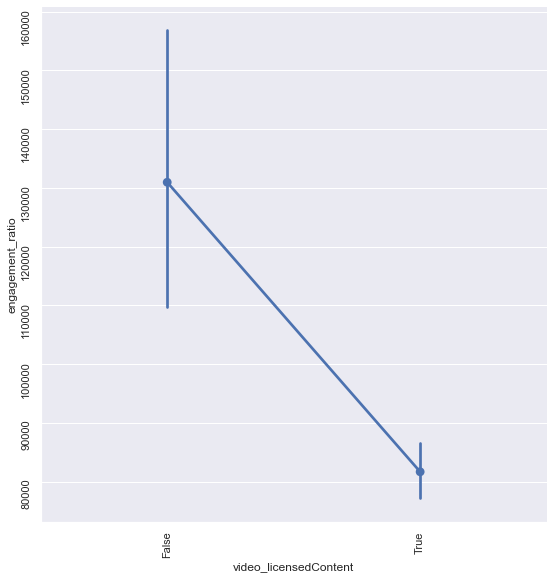

In [52]:
g = sns.PairGrid(df, x_vars=['video_licensedContent'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

In [600]:
df['is_licensed'] = df['video_licensedContent'].apply(lambda x:1 if x=='TRUE' else 0 )

In [601]:
df = df.drop('video_licensedContent', axis=1)

In [602]:
# How many days after being posted
import datetime
now = datetime.datetime.now()

def get_upload_days(df):
    df['upload_time'] = pd.to_datetime(df['upload_date'])
    
    for index in range(len(df['upload_time'])):
        df['upload_time'][index] = now - df['upload_time'][index]
    
    df['upload_time'] = df['upload_time'].astype(str)
    df['upload_days'] = df['upload_time'].apply(lambda x: x[:-21])
    
    return df['upload_days']


df['upload_days'] = get_upload_days(df=df)

<ipython-input-602-0614853466a8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['upload_time'][index] = now - df['upload_time'][index]
D:\Program Files(x86)\PYTHON\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


D:\Program Files(x86)\PYTHON\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='upload_days', ylabel='Density'>

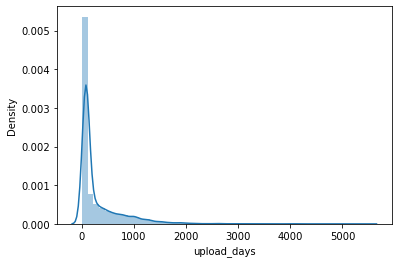

In [377]:
sns.distplot(df['upload_days'])

<AxesSubplot:xlabel='upload_days', ylabel='engagement_ratio'>

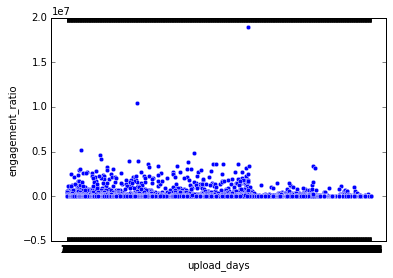

In [603]:
sns.scatterplot(x='upload_days', y='engagement_ratio', data=df)

In [604]:
df['is_upload <5'] = df['upload_days'].astype(int).apply(lambda x:1 if x<=5 else 0 )
df['is_upload 5-10'] = df['upload_days'].astype(int).apply(lambda x:1 if 5<x<=10 else 0 )
df['is_upload 10-15'] = df['upload_days'].astype(int).apply(lambda x:1 if 10<x<=15 else 0 )
df['is_upload 15-20'] = df['upload_days'].astype(int).apply(lambda x:1 if 15<x<=20 else 0 )
df['is_upload 20-25'] = df['upload_days'].astype(int).apply(lambda x:1 if 20<x<=25 else 0 )
df['is_upload 25-30'] = df['upload_days'].astype(int).apply(lambda x:1 if 25<x<=30 else 0 )
df['is_upload 30-60'] = df['upload_days'].astype(int).apply(lambda x:1 if 30<x<=60 else 0 )
df['is_upload 60-90'] = df['upload_days'].astype(int).apply(lambda x:1 if 60<x<=90 else 0 )
df['is_upload 90-120'] = df['upload_days'].astype(int).apply(lambda x:1 if 90<x<=1200 else 0 )
df['is_upload >120'] = df['upload_days'].astype(int).apply(lambda x:1 if x>30 else 0 )

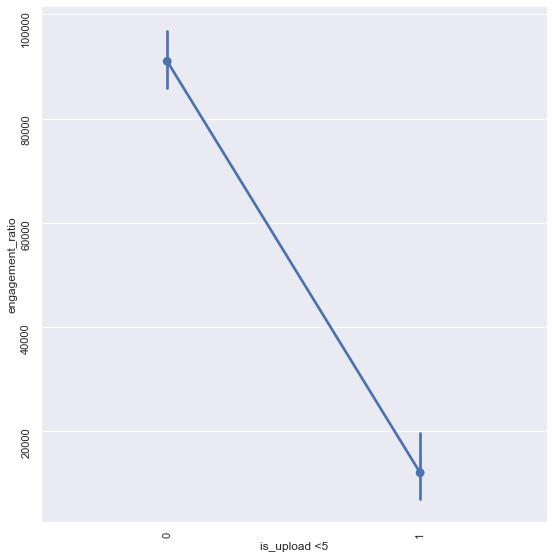

In [67]:
g = sns.PairGrid(df, x_vars=['is_upload <5'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

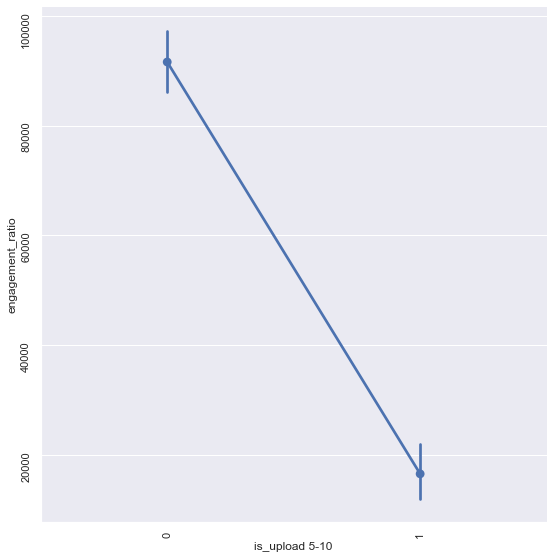

In [68]:
g = sns.PairGrid(df, x_vars=['is_upload 5-10'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90) 

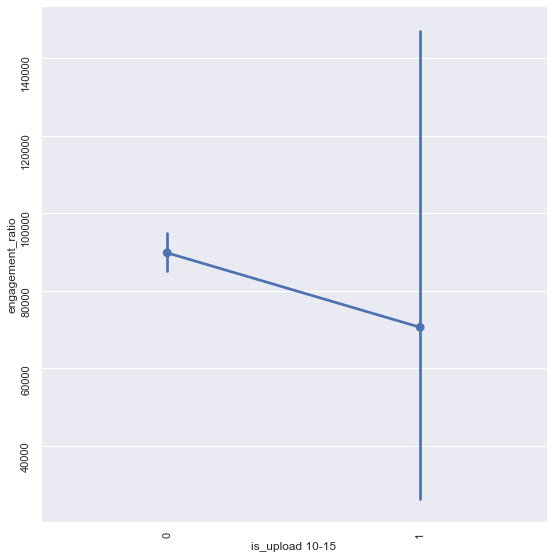

In [69]:
g = sns.PairGrid(df, x_vars=['is_upload 10-15'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

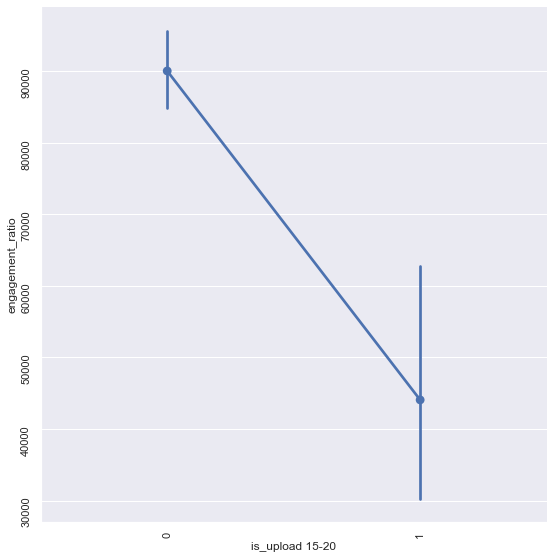

In [70]:
g = sns.PairGrid(df, x_vars=['is_upload 15-20'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

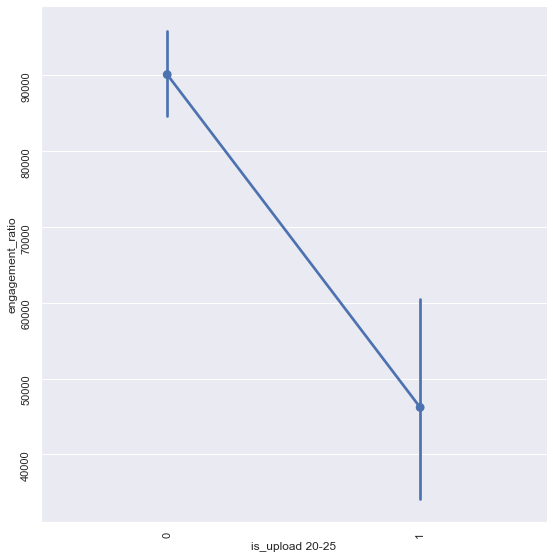

In [71]:
g = sns.PairGrid(df, x_vars=['is_upload 20-25'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

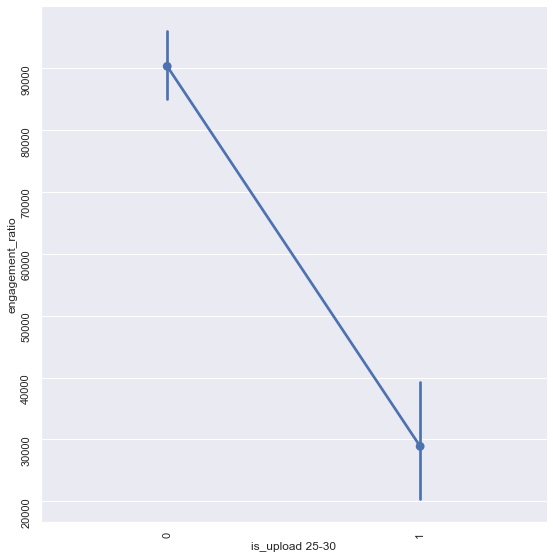

In [72]:
g = sns.PairGrid(df, x_vars=['is_upload 25-30'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

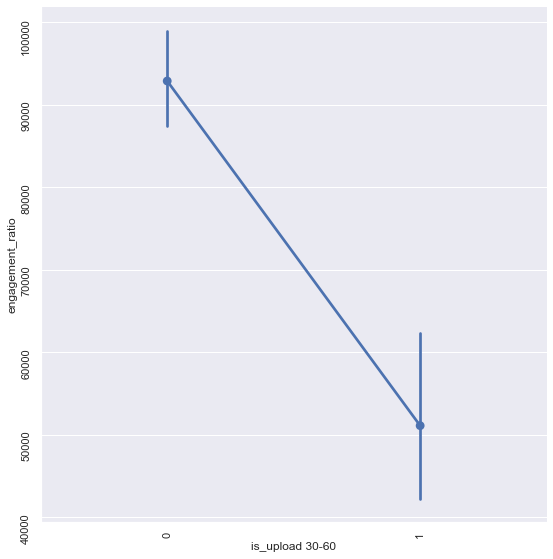

In [73]:
g = sns.PairGrid(df, x_vars=['is_upload 30-60'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

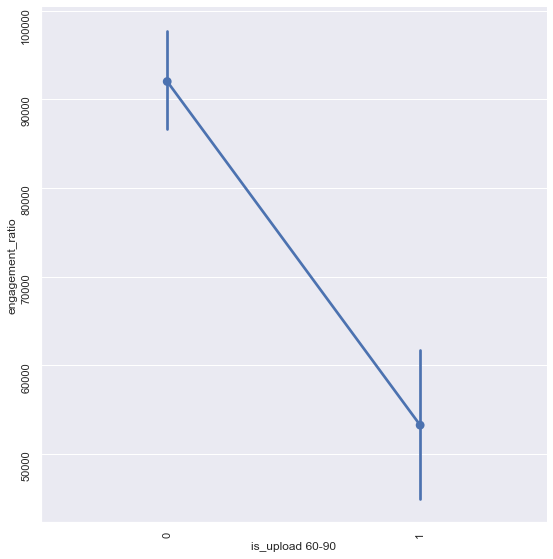

In [74]:
g = sns.PairGrid(df, x_vars=['is_upload 60-90'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

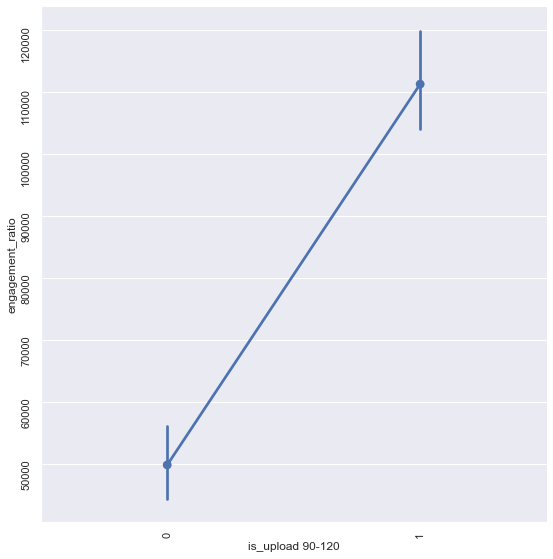

In [75]:
g = sns.PairGrid(df, x_vars=['is_upload 90-120'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

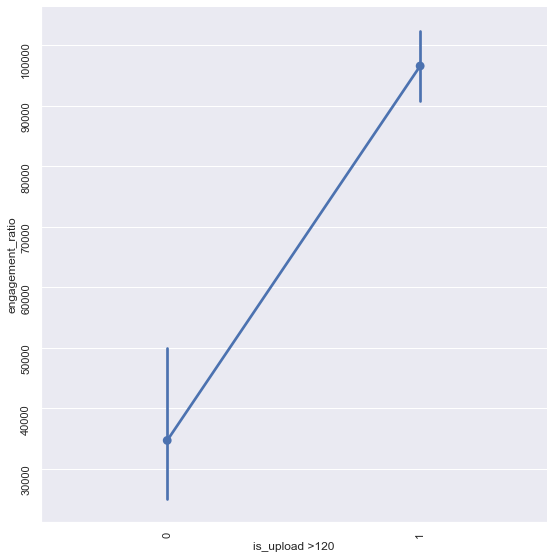

In [76]:
g = sns.PairGrid(df, x_vars=['is_upload >120'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

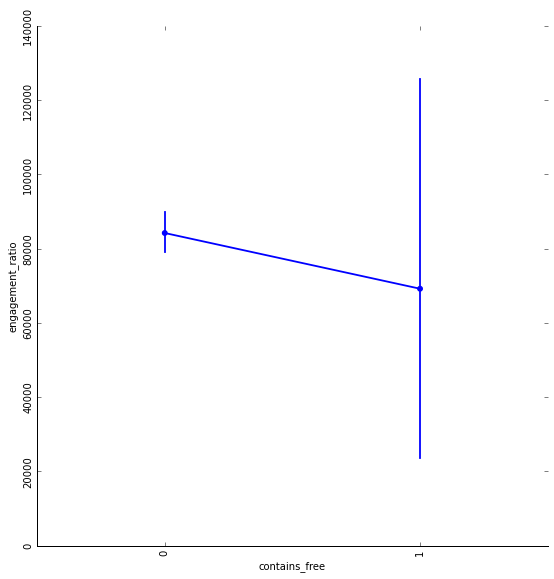

In [611]:
# updated by carrie
df['contains_free'] = df['video_title'].apply(lambda x: 1 if 'free' in x else 0)

g = sns.PairGrid(df, x_vars=['contains_free'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

In [612]:
df['channel_publishedAt'] = pd.to_datetime(df['channel_publishedAt'])

df['ch_published_yr'] = [x.year for x in df['channel_publishedAt']]

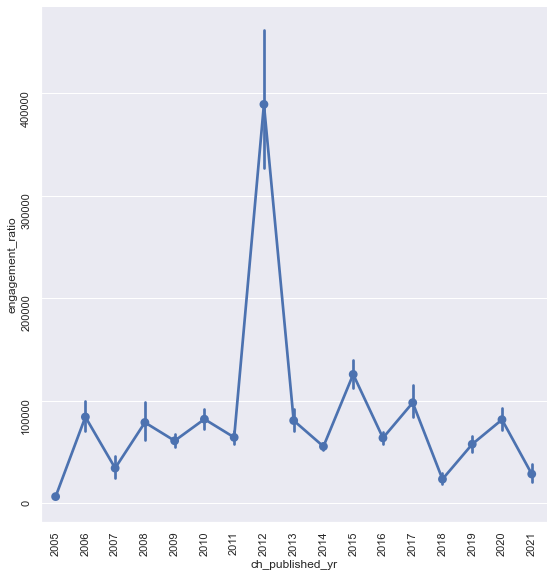

In [79]:
g = sns.PairGrid(df, x_vars=['ch_published_yr'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

In [80]:
df['ch_published_yr'].value_counts()

2014    1969
2016    1338
2006    1299
2020    1218
2015    1068
2012    1014
2018     896
2019     834
2021     786
2011     722
2010     704
2013     653
2009     593
2007     450
2008     369
2017     339
2005     292
Name: ch_published_yr, dtype: int64

In [81]:
#df = pd.get_dummies(df, prefix=['is_ch_published'], columns=['ch_published_yr'])

In [613]:
df = df.drop('channel_publishedAt', axis=1)

In [383]:
df['channel_country'].value_counts()

US    14671
GB     1291
CA     1122
AU      587
FR      253
NZ      150
SE      148
NL      147
IN      146
CY      116
ZA       74
JP       51
Name: channel_country, dtype: int64

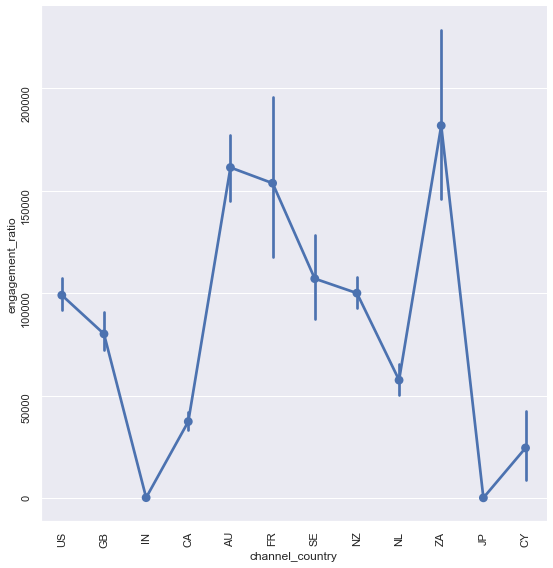

In [84]:
g = sns.PairGrid(df, x_vars=['channel_country'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

In [614]:
df = pd.get_dummies(df, prefix=['is_country'], columns=['channel_country'])

In [615]:
df = df.drop(['is_country_ZA','is_country_JP'], axis=1)

<AxesSubplot:xlabel='channel_subscriberCount', ylabel='engagement_ratio'>

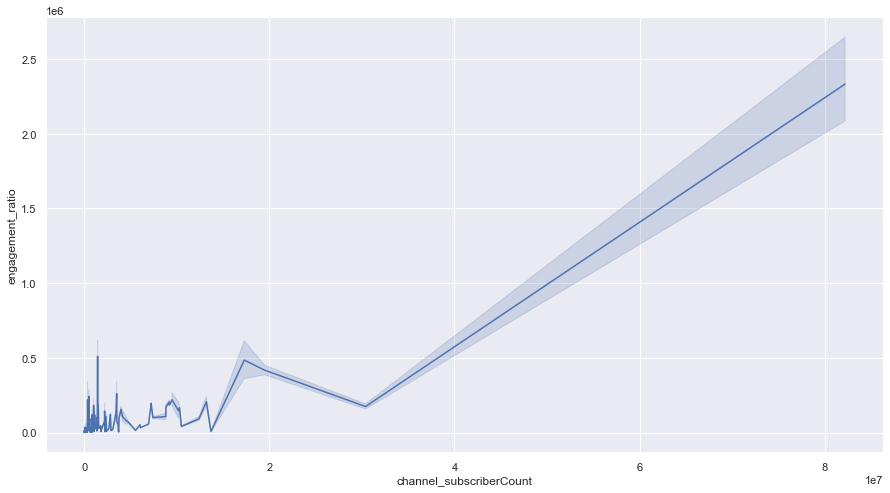

In [87]:
sns.lineplot(x='channel_subscriberCount', y='engagement_ratio', data=df)

In [88]:
df['channel_subscriberCount'].describe()

count    1.454400e+04
mean     4.171766e+06
std      9.282272e+06
min      4.000000e+00
25%      5.140000e+05
50%      1.450000e+06
75%      3.980000e+06
max      8.220000e+07
Name: channel_subscriberCount, dtype: float64

In [616]:
df['is_subscriber<10000'] = df['channel_subscriberCount'].apply(lambda x: 1 if x < 10000 else 0)
df['is_subscriber>100000'] = df['channel_subscriberCount'].apply(lambda x: 1 if  100000 <= x <= 5000000 else 0)
df['is_subscriber>5000000'] = df['channel_subscriberCount'].apply(lambda x: 1 if x > 5000000 else 0)

In [464]:
#df = df.drop('channel_subscriberCount', axis=1) # updated by carrie: tried keeping the subscriber count

In [91]:
df['channel_hiddenSubscriberCount'].value_counts()

False    14544
Name: channel_hiddenSubscriberCount, dtype: int64

In [618]:
df = df.drop('channel_hiddenSubscriberCount', axis=1)

<AxesSubplot:xlabel='channel_viewCount', ylabel='engagement_ratio'>

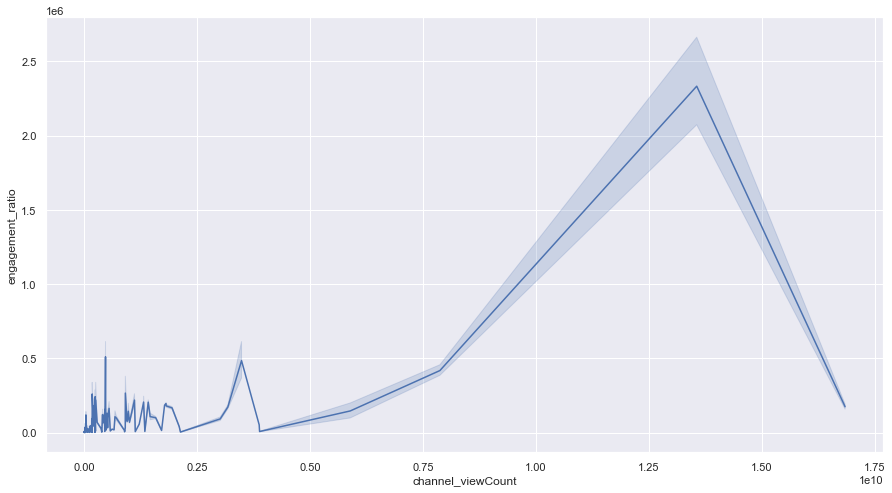

In [93]:
sns.lineplot(x='channel_viewCount', y='engagement_ratio', data=df)

In [94]:
df['channel_viewCount'].value_counts()

22933678      150
1583257366    150
661372044     150
5889578964    150
121370472     150
             ... 
38990208       20
5607299        17
201            11
241580          4
1811827768      1
Name: channel_viewCount, Length: 114, dtype: int64

In [617]:
df['is_channel_view<8000000'] = df['channel_viewCount'].apply(lambda x: 1 if x < 8000000 else 0)
df['is_subscriber>50000000'] = df['channel_viewCount'].apply(lambda x: 1 if 50000000 <= x <= 100000000  else 0)
df['is_subscriber>100000000'] = df['channel_viewCount'].apply(lambda x: 1 if x > 100000000 else 0)

In [467]:
df = df.drop('channel_viewCount', axis=1) # updated by carrie: tried keeping the channel count

In [619]:
df = df.drop(['channel_topicCategories','channel_privacyStatus'], axis=1)

<AxesSubplot:xlabel='channel_videoCount', ylabel='engagement_ratio'>

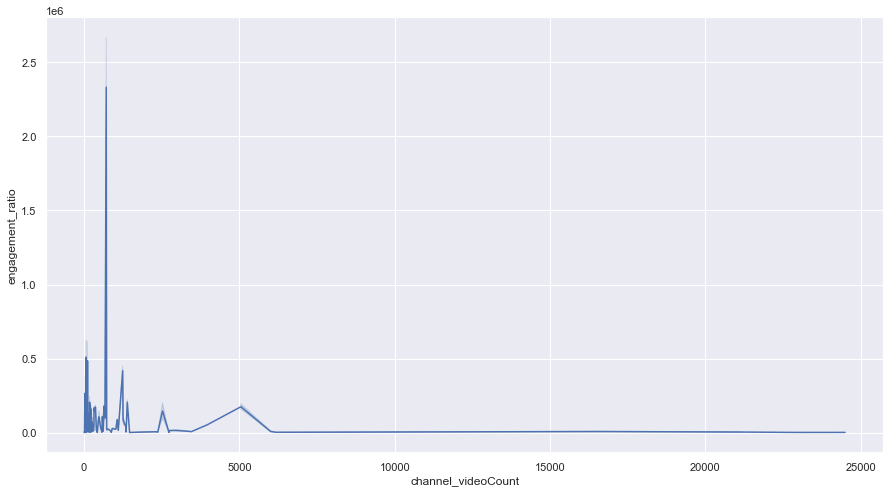

In [98]:
sns.lineplot(x='channel_videoCount', y='engagement_ratio', data=df)

In [620]:
df['is_<20_videos'] = df['channel_videoCount'].apply(lambda x: 1 if x < 20 else 0)

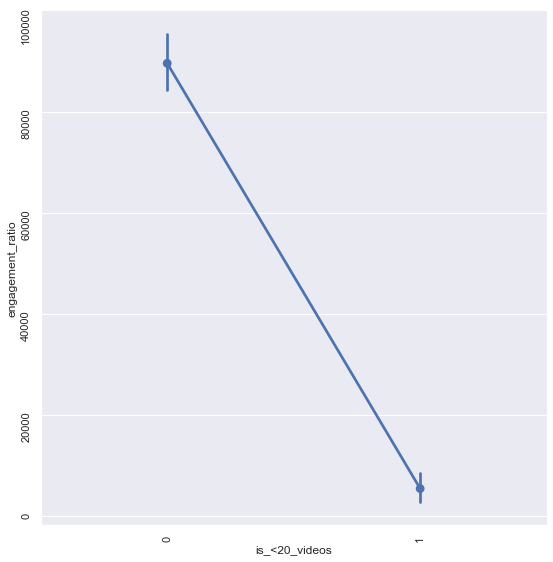

In [100]:
g = sns.PairGrid(df, x_vars=['is_<20_videos'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

In [101]:
df['channel_longUploadsStatus'].value_counts()

longUploadsUnspecified    14544
Name: channel_longUploadsStatus, dtype: int64

In [621]:
df = df.drop('channel_longUploadsStatus', axis=1)

In [394]:
df['channel_madeForKids'].value_counts()

0.0    17192
Name: channel_madeForKids, dtype: int64

In [622]:
df = df.drop('channel_madeForKids', axis=1)

In [623]:
df.columns

Index(['video_title', 'video_description_full', 'upload_date', 'view_count',
       'channel_description', 'channel_subscriberCount', 'channel_viewCount',
       'channel_keywords', 'channel_videoCount', 'engagement_ratio',
       'has_hyperlink', 'has_capital_word', 'title_length',
       'is_between_20_to_60', 'video_minutes', 'is_short', 'is_middle',
       'is_long', 'frequency', 'bag_of_words', 'cluster',
       'is__Autos & Vehicles', 'is__Comedy  ', 'is__Education  ',
       'is__Entertainment  ', 'is__Film & Animation', 'is__Gaming  ',
       'is__Howto & Style', 'is__Music  ', 'is__News & Politics',
       'is__People & Blogs', 'is__Science & Technology', 'is__Sports  ',
       'is_hd', 'is_length <=10', 'is_licensed', 'upload_time', 'upload_days',
       'is_upload <5', 'is_upload 5-10', 'is_upload 10-15', 'is_upload 15-20',
       'is_upload 20-25', 'is_upload 25-30', 'is_upload 30-60',
       'is_upload 60-90', 'is_upload 90-120', 'is_upload >120',
       'contains_free', '

In [106]:
df.head()

,video_title,upload_date,view_count,video_tags,channel_description,channel_keywords,channel_videoCount,engagement_ratio,has_hyperlink,has_capital_word,...,is_country_NZ,is_country_SE,is_country_US,is_subscriber<10000,is_subscriber>100000,is_subscriber>5000000,is_channel_view<8000000,is_subscriber>50000000,is_subscriber>100000000,is_<20_videos
0,Tether Has Lost Their Mind,2021-11-12,218804.0,"['coffeezilla', 'fake guru', 'scam', 'make mon...","I uncover scams, fraudsters and fake gurus tha...","coffeezilla ""make money online"" ""fake guru"" sc...",397,13781.0,1,0,...,0,0,1,0,1,0,0,1,0,0
1,Youtube Removes Dislikes From Videos,2021-11-11,226982.0,"['coffeezilla', 'fake guru', 'scam', 'make mon...","I uncover scams, fraudsters and fake gurus tha...","coffeezilla ""make money online"" ""fake guru"" sc...",397,30743.0,1,0,...,0,0,1,0,1,0,0,1,0,0
2,This Has To Stop...,2021-11-10,203056.0,"['coffeezilla', 'fake guru', 'scam', 'make mon...","I uncover scams, fraudsters and fake gurus tha...","coffeezilla ""make money online"" ""fake guru"" sc...",397,13879.0,1,0,...,0,0,1,0,1,0,0,1,0,0
3,Jake Paul Thought He'd Get Away With This...,2021-11-09,369053.0,"['coffeezilla', 'fake guru', 'scam', 'make mon...","I uncover scams, fraudsters and fake gurus tha...","coffeezilla ""make money online"" ""fake guru"" sc...",397,24244.0,1,0,...,0,0,1,0,1,0,0,1,0,0
4,Squid Game But It's a Crypto Scam,2021-11-04,284484.0,"['coffeezilla', 'fake guru', 'scam', 'make mon...","I uncover scams, fraudsters and fake gurus tha...","coffeezilla ""make money online"" ""fake guru"" sc...",397,16553.0,1,0,...,0,0,1,0,1,0,0,1,0,0


In [624]:
df = df.drop('upload_date', axis=1)

We also tried TFIDF, SVD and KMeans for text clustering. But it did not give an optimal result.

In [110]:
# from sklearn.feature_extraction.text import TfidfVectorizer

#Feature Transformation

#tfidf_vectorizer = TfidfVectorizer(max_features= 1000000)
#tfidf = tfidf_vectorizer.fit_transform(df['key_words'])


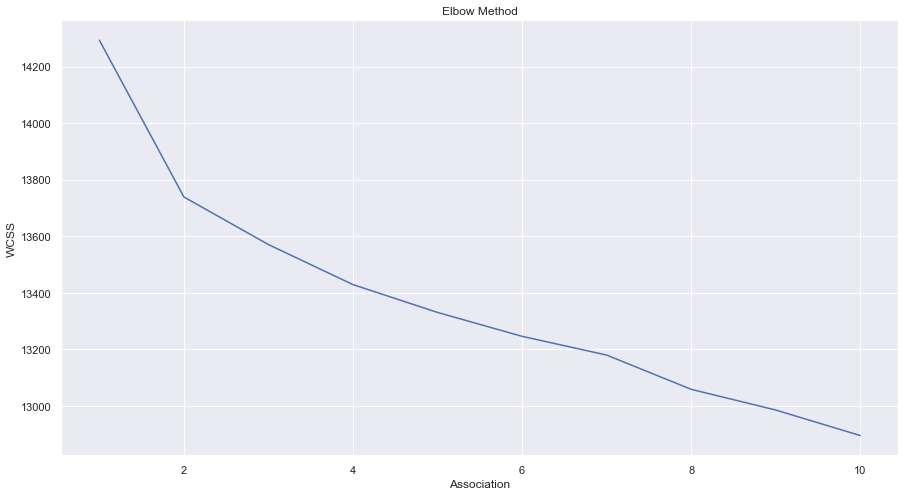

In [111]:
# Elbow method
#from sklearn.cluster import KMeans
#wcss = []

#for i in range(1, 11):
 #   kmeans = KMeans(n_clusters = i, init = 'k-means++',
  #                  max_iter = 400, n_init = 10, random_state = 0)
   # kmeans.fit(tfidf)
    #wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
#plt.plot(range(1, 11), wcss)
#plt.title('Elbow Method')
#plt.xlabel('Association')
#plt.ylabel('WCSS') #within cluster sum of squares
#plt.show()

In [112]:
#Changed to 10 based on elbow
# Transfering text into categories
#from sklearn.decomposition import TruncatedSVD
#from sklearn.cluster import KMeans
#from sklearn.pipeline import make_pipeline


#svd = TruncatedSVD(n_components=50)
#kmeans = KMeans(n_clusters=10)

#pipeline = make_pipeline(svd, kmeans)
#pipeline.fit(tfidf)

#labels = pipeline.predict(tfidf)
#print(len(labels))
#print(labels)


14544
[1 1 1 ... 1 1 1]


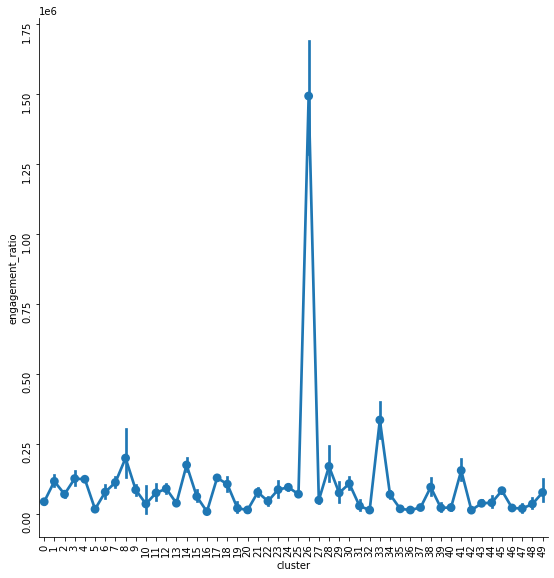

In [398]:
g = sns.PairGrid(df, x_vars=['cluster'], y_vars=['engagement_ratio'], height = 8)
g.map(sns.pointplot)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

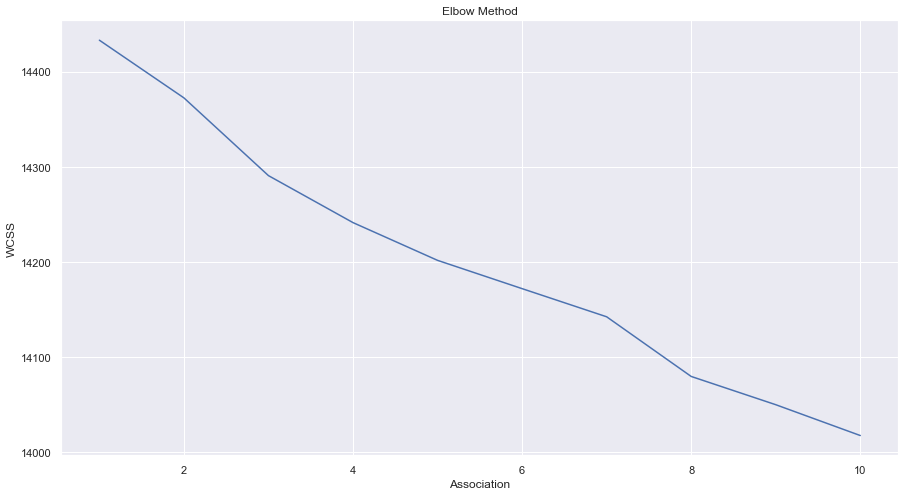

In [124]:
tfidf_vectorizer = TfidfVectorizer(max_features= 1000000, token_pattern='(?u)\\b\\w+\\b')
tfidf_3 = tfidf_vectorizer.fit_transform(df['video_title'])


from sklearn.cluster import KMeans
wcss3 = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(tfidf_3)
    wcss3.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss3)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [135]:
#********************************************************************************************Testing

In [625]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14632 entries, 0 to 14631
Data columns (total 66 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   video_title               14632 non-null  object 
 1   video_description_full    14632 non-null  object 
 2   view_count                14625 non-null  float64
 3   channel_description       14632 non-null  object 
 4   channel_subscriberCount   14632 non-null  int64  
 5   channel_viewCount         14632 non-null  int64  
 6   channel_keywords          14632 non-null  object 
 7   channel_videoCount        14632 non-null  int64  
 8   engagement_ratio          14625 non-null  float64
 9   has_hyperlink             14632 non-null  int64  
 10  has_capital_word          14632 non-null  int64  
 11  title_length              14632 non-null  int64  
 12  is_between_20_to_60       14632 non-null  int64  
 13  video_minutes             14632 non-null  float64
 14  is_sho

In [626]:
df = df.drop(['video_title', 'video_description_full', 'view_count', 'channel_description', 'channel_keywords', 'bag_of_words', 'upload_time'], axis=1)
# Updated by Carrie: depend on what are the final columns left

In [627]:
df = pd.get_dummies(df, prefix=['is_text_cluster'], columns=['cluster']) # Clusters are based on 'bag of words'

In [710]:
df.columns.values

array(['channel_subscriberCount', 'channel_videoCount',
       'engagement_ratio', 'has_hyperlink', 'has_capital_word',
       'title_length', 'is_between_20_to_60', 'video_minutes', 'is_short',
       'is_middle', 'is_long', 'frequency', 'is__Autos & Vehicles',
       'is__Comedy  ', 'is__Education  ', 'is__Entertainment  ',
       'is__Film & Animation', 'is__Gaming  ', 'is__Howto & Style',
       'is__Music  ', 'is__News & Politics', 'is__People & Blogs',
       'is__Science & Technology', 'is__Sports  ', 'is_hd',
       'is_length <=10', 'is_licensed', 'upload_days', 'is_upload <5',
       'is_upload 5-10', 'is_upload 10-15', 'is_upload 15-20',
       'is_upload 20-25', 'is_upload 25-30', 'is_upload 30-60',
       'is_upload 60-90', 'is_upload 90-120', 'is_upload >120',
       'contains_free', 'ch_published_yr', 'is_country_AU',
       'is_country_CA', 'is_country_CY', 'is_country_FR', 'is_country_GB',
       'is_country_IN', 'is_country_NL', 'is_country_NZ', 'is_country_SE',
     

In [143]:
############################### MODELING ##################################################



In [629]:
df = df.fillna({'channel_videoCount':0})

In [630]:
df = df.fillna({'view_count':0})

In [631]:
df = df.fillna({'engagement_ratio':0})

In [632]:
df['engagement_ratio'] = pd.to_numeric(df['engagement_ratio'])

In [633]:
df['has_capital_word'] = pd.to_numeric(df['has_capital_word'], errors='coerce')

In [634]:
df['has_capital_word'] = pd.to_numeric(df['has_capital_word'], errors='coerce').fillna(0).astype(np.int64)

In [635]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [699]:
df['engagement_ratio'].value_counts()

3.0         19
0.0         18
14.0        17
33.0        17
8.0         17
            ..
24007.0      1
15993.0      1
23340.0      1
141885.0     1
18944.0      1
Name: engagement_ratio, Length: 11592, dtype: int64

In [700]:
x, y = df.drop(['engagement_ratio'], axis = 1), df['engagement_ratio']


In [716]:
train_x, test_x, train_y, test_y = cv.train_test_split(x, y, train_size=.8, test_size=.2)  #updated by carrie: cv as the model selection tool increase scores

In [702]:
y.value_counts()

3.0         19
0.0         18
14.0        17
33.0        17
8.0         17
            ..
24007.0      1
15993.0      1
23340.0      1
141885.0     1
18944.0      1
Name: engagement_ratio, Length: 11592, dtype: int64

In [714]:
def class_model(model):
    classifier = model()
    calc = classifier.fit(train_x, train_y)
    print(classifier.score(test_x, test_y))
    return classifier  

In [704]:
df = df.dropna(subset=['engagement_ratio'])

In [715]:
from sklearn.linear_model import LinearRegression
#linearregression = class_model(LinearRegression)

0.575978325864716


In [717]:
# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

linearregression = LinearRegression()

# Fit dt to the training set
linearregression.fit(train_x, train_y)

# Predict the labels of the training set
y_pred_train = linearregression.predict(train_x)

# Evaluate the training set RMSE of dt
RMSE_train = (MSE(train_y, y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))

Train RMSE: 239213.56


In [707]:
from sklearn.metrics import mean_squared_error as MSE

# Compute y_pred
y_pred = linearregression.predict(test_x)

# Compute mse_dt
mse_linearregression = MSE(test_y, y_pred)

# Compute rmse_dt
rmse_lr = mse_linearregression**(1/2)

# Print rmse_dt
print("Test set RMSE of linearRegression: {:.2f}".format(rmse_lr))

Test set RMSE of linearRegression: 227369.58


In [708]:
from sklearn.model_selection import cross_val_score
# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(linearregression, train_x, train_y, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

CV RMSE: 224113.66


In [718]:
print(linearregression.score(test_x, test_y))

0.677490055505081


In [695]:
from sklearn import tree
dt = class_model(tree.DecisionTreeRegressor)

0.5888053767274248


In [678]:
# Instantiate dt
dt = tree.DecisionTreeRegressor(max_depth=6,
                           min_samples_leaf=0.01,
                           random_state=4)

# Fit dt to the training set
dt.fit(train_x, train_y)
calc = dt.fit(train_x, train_y)
print(dt.score(test_x, test_y))

0.6462470833881486


In [679]:
from sklearn.metrics import mean_squared_error as MSE

# Fit dt to the training set
dt.fit(train_x, train_y)

# Predict the labels of the training set
y_pred_train = dt.predict(train_x)

# Evaluate the training set RMSE of dt
RMSE_train = (MSE(train_y, y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))

Train RMSE: 228930.81


In [687]:
from sklearn.metrics import mean_squared_error as MSE

# Compute y_pred
y_pred = dt.predict(test_x)

# Compute mse_dt
mse_dt = MSE(test_y, y_pred)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

Test set RMSE of dt: 160503.74


In [688]:
from sklearn.model_selection import cross_val_score
# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, train_x, train_y, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

CV RMSE: 243613.93


In [692]:
# Instantiate rf
rf = RandomForestRegressor()

# Fit rf to the training set
rf.fit(train_x, train_y)
calc = rf.fit(train_x, train_y)
print(rf.score(test_x, test_y))

0.7190521750632404


In [693]:
from sklearn.metrics import mean_squared_error as MSE

# Fit rf to the training set
rf.fit(train_x, train_y)

# Predict the labels of the training set
y_pred_train = rf.predict(train_x)

# Evaluate the training set RMSE of rf
RMSE_train = (MSE(train_y, y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))

Train RMSE: 87412.01


In [694]:
from sklearn.metrics import mean_squared_error as MSE

# Compute y_pred
y_pred = rf.predict(test_x)

# Compute mse_rf
mse_rf = MSE(test_y, y_pred)

# Compute rmse_rf
rmse_rf = mse_rf**(1/2)

# Print rmse_rf
print("Test set RMSE of rf: {:.2f}".format(rmse_rf))

Test set RMSE of rf: 144209.41


In [685]:
from sklearn.model_selection import cross_val_score
# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(rf, train_x, train_y, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

CV RMSE: 234004.95


In [509]:
from matplotlib import pyplot

In [510]:
importance = dt.feature_importances_

In [511]:
from matplotlib.pyplot import figure

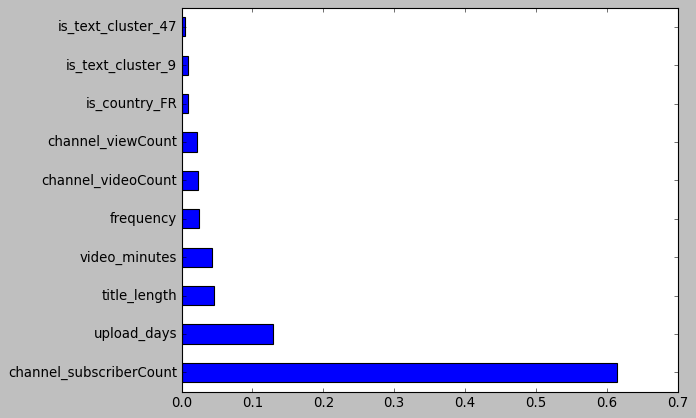

In [666]:
fig = (pd.Series(rf.feature_importances_, index=x.columns)
   .nlargest(10)
   .plot(kind='barh'))  
plt.style.use('classic')


In [664]:
df = df.drop('channel_viewCount', axis=1)

In [711]:
df.columns.values

array(['channel_subscriberCount', 'channel_videoCount',
       'engagement_ratio', 'has_hyperlink', 'has_capital_word',
       'title_length', 'is_between_20_to_60', 'video_minutes', 'is_short',
       'is_middle', 'is_long', 'frequency', 'is__Autos & Vehicles',
       'is__Comedy  ', 'is__Education  ', 'is__Entertainment  ',
       'is__Film & Animation', 'is__Gaming  ', 'is__Howto & Style',
       'is__Music  ', 'is__News & Politics', 'is__People & Blogs',
       'is__Science & Technology', 'is__Sports  ', 'is_hd',
       'is_length <=10', 'is_licensed', 'upload_days', 'is_upload <5',
       'is_upload 5-10', 'is_upload 10-15', 'is_upload 15-20',
       'is_upload 20-25', 'is_upload 25-30', 'is_upload 30-60',
       'is_upload 60-90', 'is_upload 90-120', 'is_upload >120',
       'contains_free', 'ch_published_yr', 'is_country_AU',
       'is_country_CA', 'is_country_CY', 'is_country_FR', 'is_country_GB',
       'is_country_IN', 'is_country_NL', 'is_country_NZ', 'is_country_SE',
     

In [514]:
# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

In [546]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor


# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4,
                               n_estimators=200,
                               random_state=2)

# Fit gb to the training set
gb.fit(train_x, train_y)

# Predict test set labels
y_pred_Gboost = gb.predict(test_x)

# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute MSE
mse_test = MSE(test_y, y_pred)

# Compute RMSE
rmse_test = mse_test**(1/2)

# Calculate accuracy score
accuracy = accuracy_score(test_y, y_pred)
print('Soft Voting Classifier: {:.3f}'.format(accuracy))

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [547]:
print(gb.score(test_x, test_y))

0.5255539812925154


In [548]:
# Fit gb to the training set
gb.fit(train_x, train_y)

# Predict the labels of the training set
y_pred_train = gb.predict(train_x)

# Evaluate the training set RMSE of rf
RMSE_train = (MSE(train_y, y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))

Train RMSE: 113002.50


In [549]:
# Compute y_pred
y_pred = gb.predict(test_x)

# Compute mse_rf
mse_gb = MSE(test_y, y_pred)

# Compute rmse_rf
rmse_gb = mse_rf**(1/2)

# Print rmse_rf
print("Test set RMSE of gb: {:.2f}".format(rmse_gb))

Test set RMSE of gb: 212166.55


In [550]:
MSE_CV_scores = - cross_val_score(gb, train_x, train_y, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

CV RMSE: 287241.18
